[exercises](dft.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
amplitudes = 1, 0.75, 0.5, 0.25, 0.125
frequencies = 200, 400, 600, 800, 1000  # Hz
phaseshifts = 0, 0, 90, 90, -90  # degree
duration = 1  # second
fs = 44100  # Hz

# parameters as row vectors
amplitudes = np.asarray(amplitudes).reshape(1, -1)
frequencies = np.asarray(frequencies).reshape(1, -1)
phaseshifts = np.asarray(phaseshifts).reshape(1, -1)

# time values as column vector
t = (np.arange(np.ceil(duration * fs)) / fs).reshape(-1, 1)

cosines = amplitudes * np.cos(2 * np.pi * frequencies * t + np.deg2rad(phaseshifts))

Split into several variables (e.g. for listening), each holding a row (no copies of the data are made!):

In [3]:
x1, x2, x3, x4, x5 = cosines.T

In [4]:
x6 = np.sum(cosines, axis=1)

In [5]:
six_signals = np.column_stack((cosines, x6))

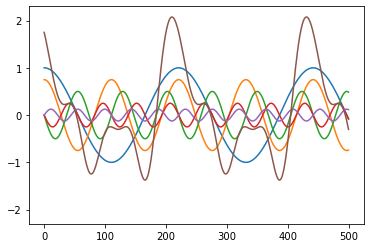

In [6]:
plt.plot(six_signals[:500])
plt.ylim(-2.3, 2.3);

When playing back with a sound card or when writing to a sound file, the values are automatically clipped to a range from -1 to 1, leading to heavy distortions for signals that exceed this range:

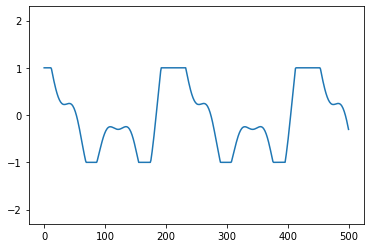

In [7]:
plt.plot(np.clip(x6[:500], -1, 1))
plt.ylim(-2.3, 2.3);

To avoid this clipping, we should scale the signal values to $\pm 1$ beforehand:

In [8]:
x6_norm = x6 / np.max(np.abs(x6))

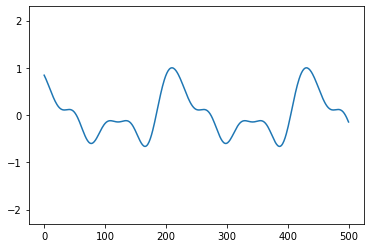

In [9]:
plt.plot(x6_norm[:500])
plt.ylim(-2.3, 2.3);

In [10]:
def naive_fourier_transform(x):
    """Naive implementation of the DFT equation.
    
    The input must be a one-dimensional array.
    WARNING: this implementation is extremely inefficient!
    
    """
    N = len(x)
    n = np.arange(N)
    return np.array([np.sum(x * np.exp(-1j * 2 * np.pi * k * n / N))
                     for k in range(N)])

In case you wonder what that last thing is, up there inside of the `np.array(...)`: it's a *list comprehension*!
This is a really nice feature of Python, to learn more about them, have a look at [List Comprehensions, Generators, Generator Expressions](http://nbviewer.ipython.org/github/mgeier/python-audio/blob/master/misc/comprehensions-and-generators.ipynb).

In [11]:
#X1_naive = naive_fourier_transform(x1)  # takes much too long!

Complexity of naive implementation: $\mathcal{O}(N^2)$

In [12]:
X1_naive = naive_fourier_transform(x1[:1000])

Matrix multiplication:
One could calculate the DFT by multiplying a matrix containing the values of the exponential function by the vector $x$.
The computation could *theoretically* be a bit more efficient, since the whole matrix multiplication can be done in C or Fortran (or whatever NumPy uses) instead of native Python.
But this only matters for very short signals, because the memory requirements would be quadratic instead of linear!
For example, storing the above-mentioned matrix for a one-second signal @ 44.1 kHz would need ...

In [13]:
44100**2 * np.dtype('float64').itemsize

15558480000

... thats about 14.5 GB of memory!

In [14]:
X1_fft = np.fft.fft(x1)

Algorithmic complexity of FFT: $\mathcal{O}(N\log_2N)$

In [15]:
X1_fft = np.fft.fft(x1[:1000])

In [16]:
np.max(np.abs(X1_fft - X1_naive))

7.782991408489731e-11

In [17]:
np.max(np.abs(X1_naive))

356.59263628672306

Maximum error in decibel (where 0 dB is the absolute maximum value of `X1_naive`):

In [18]:
20 * np.log10(np.max(np.abs(X1_fft - X1_naive)) / np.max(np.abs(X1_naive)))

-253.2205163924059

Maximum dynamic range of a 16-bit signal: about 96 dB.
This does not depend on the sampling rate.

In [19]:
20 * np.log10(2**16)

96.32959861247399

In [20]:
cosine_spectra = np.fft.fft(cosines, axis=0)
X6 = np.fft.fft(x6)

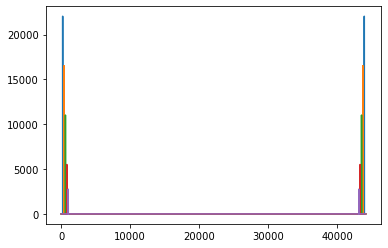

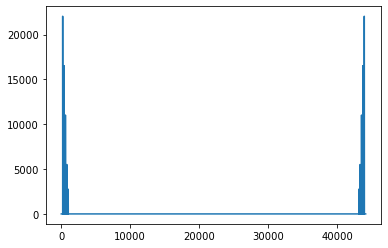

In [21]:
plt.plot(np.abs(cosine_spectra))
plt.figure()
plt.plot(np.abs(X6));

Note the warning message when plotting a complex signal!

In [22]:
# TODO: phase plot

It's probably best to write your own plotting functions for spectra, but you should also have a look at [matplotlib.pyplot.magnitude_spectrum()](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.magnitude_spectrum) and [matplotlib.pyplot.phase_spectrum()](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.phase_spectrum).

In [23]:
x1_ifft = np.fft.ifft(cosine_spectra[:, 0])

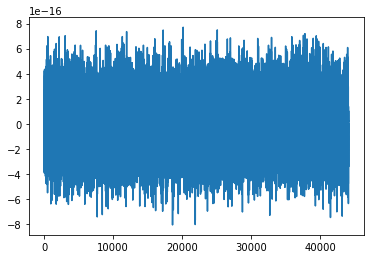

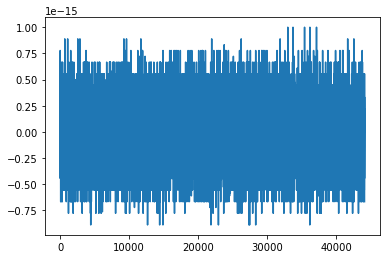

In [24]:
plt.figure()
plt.plot(x1_ifft.imag)
plt.figure()
plt.plot(x1_ifft.real - x1);

The maximum of the imaginary part is in the order of magnitude of $10^{-15}$, same for the difference of the real part compared to the original signal $x_1$.

In [25]:
def plot_fft(x, fs):
    """plot of the DFT of a signal x showing the magnitude and the phase.
    
    x  ... signal (1d-array)
    fs ... sampling frequency (int)
    
    """
    X = np.fft.fft(x)
    f = np.arange(0, fs, fs/len(x))
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
    
    ax1.plot(f, np.abs(X), 'x')
    ax1.set_title('magnitude')
    ax1.set_xlabel('f in Hz')
    
    ax2.plot(f, np.angle(X), 'x')
    ax2.set_title('phase')
    ax2.set_xlabel('f in Hz');

The phase calculation using `np.angle()` results in numerical artefacts which are random between $\pi$ and $-\pi$. For the calculation of the phase the arctan() is used. Due to the numerical artefacts you get arctan(small deviation/small deviation) which can result in a big deviation. The phase is periodical to $2\pi$ so the calculated phase with the numerical artefacts is shown in this interval.

Theoretically the phase should have a peak at the frequency of the cosine. Apart from that it is zero.

In [26]:
def plot_rfft(x, fs):
    """plot of the DFT of a real signal x showing the magnitude and the phase.
    
    x  ... signal (1d-array)
    fs ... sampling frequency (int)
    
    """
    X = np.fft.rfft(x)
    f = np.arange(0, fs, fs/len(x))
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
    
    ax1.plot(f, np.abs(X), 'x')
    ax1.set_title('magnitude')
    ax1.set_xlabel('f in Hz')
    
    ax2.plot(f, np.angle(X), 'x')
    ax2.set_title('phase')
    ax2.set_xlabel('f in Hz');

Which parameters are visible?

* time domain: amplitude, frequency, duration. Also the phase, if you look closely.

* frequency domain: amplitude, frequency. Phase not that easily. Duration not visible.

<p xmlns:dct="http://purl.org/dc/terms/">
  <a rel="license"
     href="http://creativecommons.org/publicdomain/zero/1.0/">
    <img src="http://i.creativecommons.org/p/zero/1.0/88x31.png" style="border-style: none;" alt="CC0" />
  </a>
  <br />
  To the extent possible under law,
  <span rel="dct:publisher" resource="[_:publisher]">the person who associated CC0</span>
  with this work has waived all copyright and related or neighboring
  rights to this work.
</p>